In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**Importing the necessary Libraries**

In [ ]:
import os
import random
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

**Importing the Dataset**

In [ ]:
DM1="/content/drive/MyDrive/Deep Fake/Dataset/DM/Dalle/1_fake"
DM2="/content/drive/MyDrive/Deep Fake/Dataset/DM/glide_100_10/1_fake"
DM3="/content/drive/MyDrive/Deep Fake/Dataset/DM/ldm_100/1_fake"
GAN1="/content/drive/MyDrive/Deep Fake/Dataset/GAN/biggan"
GAN2="/content/drive/MyDrive/Deep Fake/Dataset/GAN/gaugan"
GAN3="/content/drive/MyDrive/Deep Fake/Dataset/GAN/stargan"
DM1_lis=os.listdir(DM1)
DM2_lis=os.listdir(DM2)
DM3_lis=os.listdir(DM3)
GAN1_lis=os.listdir(GAN1)
GAN2_lis=os.listdir(GAN2)
GAN3_lis=os.listdir(GAN3)

In [ ]:
print(len(DM1_lis))
print(len(DM2_lis))
print(len(DM3_lis))
print(len(GAN1_lis))
print(len(GAN2_lis))
print(len(GAN3_lis))

1000
1000
1001
1200
1170
1131


**Creating Diffusion Model and GAN Dataset**

In [ ]:
DM_dataset=[]
GAN_dataset=[]
for i in range(len(DM1_lis)):
   DM1_lis[i]=DM1+'/'+DM1_lis[i]
   DM_dataset.append([DM1_lis[i],1])

for i in range(len(DM2_lis)):
   DM2_lis[i]=DM2+'/'+DM2_lis[i]
   DM_dataset.append([DM2_lis[i],1])

for i in range(len(DM3_lis)):
   DM3_lis[i]=DM3+'/'+DM3_lis[i]
   DM_dataset.append([DM3_lis[i],1])

for i in range(len(GAN1_lis)):
   GAN1_lis[i]=GAN1+'/'+GAN1_lis[i]
   GAN_dataset.append([GAN1_lis[i],0])

for i in range(len(GAN2_lis)):
   GAN2_lis[i]=GAN2+'/'+GAN2_lis[i]
   GAN_dataset.append([GAN2_lis[i],0])

for i in range(len(GAN3_lis)):
   GAN3_lis[i]=GAN3+'/'+GAN3_lis[i]
   GAN_dataset.append([GAN3_lis[i],0])

In [ ]:
print(len(GAN_dataset))
print(len(DM_dataset))

3501
3001


Shuffling the Dataset

In [ ]:
random.shuffle(GAN_dataset)
random.shuffle(DM_dataset)

In [ ]:
dataset = GAN_dataset[:1500] + DM_dataset[:1500]

In [ ]:
random.shuffle(dataset)

In [ ]:
print(dataset[2])


['/content/drive/MyDrive/Deep Fake/Dataset/DM/ldm_100/1_fake/ahwxcijnxm.png', 1]


**Creating Training and Validation dataset**

In [ ]:
X_train=[]
y_train=[]
for x in dataset:
    X_train.append(x[0])
    y_train.append(x[1])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


Resizing the image according to model's input

In [ ]:
def resize_image_3d(image_array, target_shape=(224, 224, 3)):
    if len(image_array.shape) != 3 or image_array.shape[2] != target_shape[2]:
        raise ValueError(f"Input array must have shape (height, width, {target_shape[2]})")

    resized_image = np.array(Image.fromarray(image_array).resize((target_shape[1], target_shape[0])))

    return resized_image


**Preprocessing**

In [ ]:
Im_train = []
Y_train = []

for i in range(len(X_train)):
    img = Image.open(X_train[i])
    im_array = np.array(img)
    if len(im_array.shape) != 3:
        continue
    else:
        im_array = resize_image_3d(im_array)
        Im_train.append(im_array)
        Y_train.append(y_train[i])

Im_valid = []
Y_val = []

for i in range(len(X_val)):
    img = Image.open(X_val[i])
    im_array = np.array(img)
    if len(im_array.shape) != 3:
        continue
    else:
        im_array = resize_image_3d(im_array)
        Im_valid.append(im_array)
        Y_val.append(y_val[i])


Defining the parameters and hyperparameters

In [ ]:
num_classes = 2
batch_size = 30
epochs = 10
learning_rate = 0.0005

**Loading the base model(Resnet50)**

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 [==============================] - 1s 0us/step


Freezing the layers of Resnet 50

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Adding more layers for classification

In [ ]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(num_classes, activation='softmax'))

Compiling the model

In [ ]:
sgd_optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(
    optimizer=sgd_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
Im_train = np.array(Im_train)
Y_train = np.array(Y_train)
Im_valid = np.array(Im_valid)
Y_val = np.array(Y_val)

Encoding the output using One Hot Encoding

In [ ]:
encoder = OneHotEncoder(sparse=False)
Y_train_encoded = encoder.fit_transform(Y_train.reshape(-1, 1))
Y_val_encoded = encoder.transform(Y_val.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
print("Encoder categories:", encoder.categories_)
label=np.array([0,1])
print(encoder.transform(label.reshape(-1, 1)))

Encoder categories: [array([0, 1])]
[[1. 0.]
 [0. 1.]]


**Training the Model**

In [ ]:
history = model.fit(
    Im_train, Y_train_encoded,
    epochs=epochs,
    validation_data=(Im_valid, Y_val_encoded)
)

Epoch 1/10
85/85 [==============================] - 567s 7s/step - loss: 0.5357 - accuracy: 0.7422 - val_loss: 0.3903 - val_accuracy: 0.8000
Epoch 2/10
85/85 [==============================] - 573s 7s/step - loss: 0.3415 - accuracy: 0.8507 - val_loss: 0.3344 - val_accuracy: 0.8367
Epoch 3/10
85/85 [==============================] - 540s 6s/step - loss: 0.2925 - accuracy: 0.8819 - val_loss: 0.3095 - val_accuracy: 0.8567
Epoch 4/10
85/85 [==============================] - 547s 6s/step - loss: 0.2649 - accuracy: 0.8922 - val_loss: 0.2951 - val_accuracy: 0.8733
Epoch 5/10
85/85 [==============================] - 578s 7s/step - loss: 0.2417 - accuracy: 0.9070 - val_loss: 0.2842 - val_accuracy: 0.8867
Epoch 6/10
85/85 [==============================] - 505s 6s/step - loss: 0.2259 - accuracy: 0.9152 - val_loss: 0.2818 - val_accuracy: 0.8933
Epoch 7/10
85/85 [==============================] - 535s 6s/step - loss: 0.2172 - accuracy: 0.9204 - val_loss: 0.2741 - val_accuracy: 0.8967
Epoch 8/10
85

**Learning Curves**


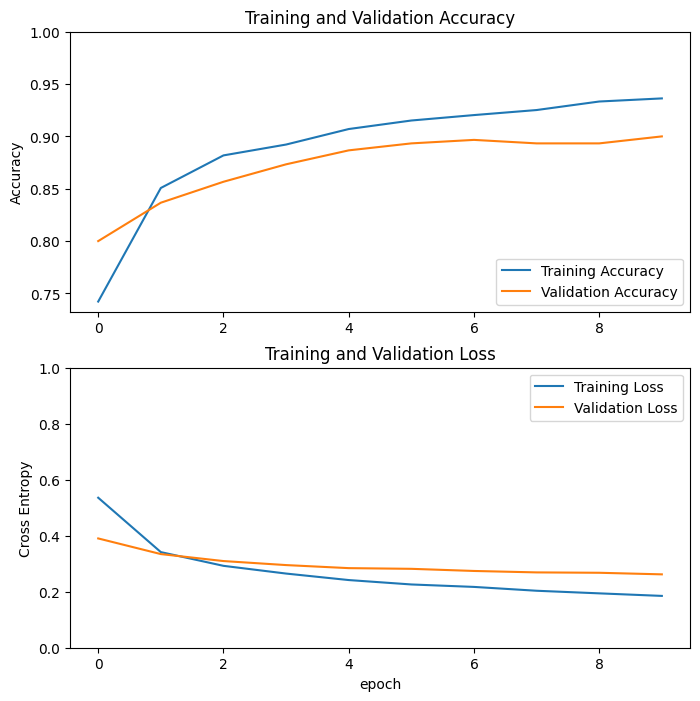

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine Tuning Model**

Unfreezing the last 10 layers

In [ ]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:40]:
  layer.trainable = False

In [ ]:
sgd_optimizer = optimizers.SGD(learning_rate=learning_rate/10, momentum=0.9)
model.compile(
    optimizer=sgd_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Traing the model again

In [ ]:
history = model.fit(
    Im_train, Y_train_encoded,
    epochs=5,
    validation_data=(Im_valid, Y_val_encoded)
)

Epoch 1/5
85/85 [==============================] - 532s 6s/step - loss: 0.1742 - accuracy: 0.9411 - val_loss: 0.2620 - val_accuracy: 0.9000
Epoch 2/5
85/85 [==============================] - 504s 6s/step - loss: 0.1742 - accuracy: 0.9411 - val_loss: 0.2620 - val_accuracy: 0.9000
Epoch 3/5
85/85 [==============================] - 505s 6s/step - loss: 0.1742 - accuracy: 0.9411 - val_loss: 0.2620 - val_accuracy: 0.9000
Epoch 4/5
85/85 [==============================] - 538s 6s/step - loss: 0.1742 - accuracy: 0.9411 - val_loss: 0.2620 - val_accuracy: 0.9000
Epoch 5/5
85/85 [==============================] - 537s 6s/step - loss: 0.1742 - accuracy: 0.9411 - val_loss: 0.2620 - val_accuracy: 0.9000


**Saving the Model**

In [ ]:
fine_tuned_model_path = '/content/drive/MyDrive/Deep Fake/fine_tuned_model.h5'
model.save(fine_tuned_model_path)

**Testing the Model**

Loading the files



In [50]:
gan="/content/drive/MyDrive/Deep Fake/Dataset/GAN/gaugan"
dm="/content/drive/MyDrive/Deep Fake/Dataset/DM/Dalle/1_fake"
DM_lis=os.listdir(dm)
GAN_lis=os.listdir(gan)

Creating testing dataset

In [51]:
GAN_dataset=[]
DM_dataset=[]
for i in range(len(DM_lis)):
   DM_lis[i]=dm+'/'+DM_lis[i]
   DM_dataset.append([DM_lis[i],1])

for i in range(len(GAN_lis)):
   GAN_lis[i]=gan+'/'+GAN_lis[i]
   GAN_dataset.append([GAN_lis[i],0])

In [52]:
dataset = GAN_dataset[:200] + DM_dataset[:200]

In [53]:
random.shuffle(dataset)

In [54]:
X_test=[]
y_test=[]
for x in dataset:
    X_test.append(x[0])
    y_test.append(x[1])

In [55]:
Im_test = []
Y_test = []

for i in range(len(X_test)):
    img = Image.open(X_test[i])
    im_array = np.array(img)
    if len(im_array.shape) != 3:
        continue
    else:
        im_array = resize_image_3d(im_array)
        Im_test.append(im_array)
        Y_test.append(y_test[i])

In [56]:
Im_test = np.array(Im_test)
Y_test = np.array(Y_test)

In [57]:
Y_test_encoded = encoder.transform(Y_test.reshape(-1, 1))


**Evaluating the Performance of model**



In [58]:
evaluation = model.evaluate(Im_test, Y_test_encoded)

13/13 [==============================] - 74s 6s/step - loss: 0.1880 - accuracy: 0.9400


In [59]:
print(evaluation)

[0.1880301982164383, 0.9399999976158142]


In [60]:
accuracy = evaluation[1]

print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.9399999976158142
